In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import graphviz

In [2]:
df = pd.read_csv("Datasets/KenPom Barttorvik.csv")
df

,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,...,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK
0,2024,MAC,17,61,1,1079,2,Akron,14,64,...,276,238,199,19,176,164,47,122,51,249
1,2024,SEC,28,63,3,1078,3,Alabama,4,4,...,13,33,8,156,106,10,314,2,263,7
2,2024,P12,24,63,3,1077,8,Arizona,2,16,...,16,50,37,196,7,195,134,8,14,47
3,2024,SEC,28,64,4,1076,12,Auburn,4,64,...,58,86,76,127,69,59,284,12,8,69
4,2024,B12,7,63,3,1075,14,Baylor,3,32,...,274,31,22,304,34,97,254,15,155,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,2008,BE,8,1,1,5,235,West Virginia,7,16,...,225,18,115,181,61,209,16,22,32,49
1075,2008,SB,26,1,1,4,236,Western Kentucky,12,16,...,111,160,179,55,131,127,214,27,28,203
1076,2008,BSth,10,4,4,3,239,Winthrop,13,64,...,301,231,206,89,236,339,190,170,12,179
1077,2008,B10,6,3,3,2,240,Wisconsin,3,16,...,301,51,35,98,12,118,117,60,2,57


In [3]:
conditions = [
    (df['ROUND'] == 1),
    (df['ROUND'] == 2),
    (df['ROUND'] == 4),
    (df['ROUND'] == 8),
    (df['ROUND'] == 16),
    (df['ROUND'] == 32),
    (df['ROUND'] == 64)
]

values = [6, 5, 4, 3, 2, 1, 0]

# Create a new column based on conditions
df['WINS'] = np.select(conditions, values, default=None)
df.tail(2)

,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,...,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,WINS
1077,2008,B10,6,3,3,2,240,Wisconsin,3,16,...,51,35,98,12,118,117,60,2,57,2
1078,2008,A10,1,1,1,1,244,Xavier,3,8,...,149,92,63,147,20,86,4,44,85,3


In [4]:
df_train = df[df['YEAR'] != 2024]
df_train = df_train[df_train['YEAR'] >= 2019]
df_train = df_train[df_train['ROUND'] < 68]
print(df_train.shape)
df_test = df[df['YEAR'] == 2024]
df_test = df_test[df_test['ROUND'] != 68]



(256, 104)


In [5]:
X_train = df_train.drop(['TEAM', 'CONF','CONF ID','QUAD NO', 'QUAD ID','TEAM NO','TEAM ID','ROUND','YEAR','ROUND','WINS'], axis=1)
y_train = df_train['WINS']
X_test = df_test.drop(['TEAM', 'CONF','CONF ID','QUAD NO', 'QUAD ID','TEAM NO','TEAM ID','ROUND','YEAR','ROUND','WINS'], axis=1)  
y_test = df_test['WINS']

In [6]:
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [7]:
results = []
TrainR2 = []
TestR2 = []
depth = []
X_train.head(2)
y_train.head(2)
X_train

,SEED,K TEMPO,K TEMPO RANK,KADJ T,KADJ T RANK,K OFF,KO RANK,KADJ O,KADJ O RANK,K DEF,...,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK
68,-1.623798,1.684815,-1.680669,2.055138,-1.791024,0.446781,-0.622455,0.750459,-0.717107,-1.290690,...,-1.795242,-0.927368,-1.255656,1.908508,-0.819179,0.009922,-0.033280,-0.610228,-1.086163,-0.945880
69,-1.407291,1.712103,-1.699655,1.891331,-1.743260,0.943913,-0.927229,1.457245,-0.969994,0.179592,...,-1.766449,-1.135273,-1.307109,0.257807,-0.934140,0.744419,-0.033280,-0.945323,-0.230337,-0.706332
70,0.541266,0.310610,-0.645932,0.419928,-0.577828,-1.646641,2.649853,-0.799119,1.204837,-0.093461,...,-0.576370,0.372036,-0.638219,-0.425915,-0.453394,1.458513,-0.618521,2.756683,-0.515612,-0.610512
71,-0.108253,0.669920,-1.101596,0.900808,-1.313388,-0.637967,0.773088,0.113040,-0.177614,-0.361401,...,-1.276981,-1.239225,-0.000201,1.683856,-0.902787,1.448311,-0.033280,0.778025,-0.672514,-0.792569
72,0.108253,0.137562,-0.418100,0.121642,-0.253035,-0.713406,0.965576,0.129972,-0.228191,-0.027534,...,-0.278850,0.995749,-0.802869,-0.269635,-0.411590,1.019855,-0.407450,0.937594,-0.415766,-0.763823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,-0.974279,-1.484180,1.471007,-1.520080,1.390033,1.112591,-0.975351,1.175769,-0.851980,-0.390894,...,1.362308,0.070574,1.265544,-0.562659,-0.714669,-1.234641,0.993291,-0.961280,-0.686777,-0.639258
336,0.108253,-0.432677,0.806497,-0.538066,0.683132,-1.099711,1.382635,-0.909452,0.968808,-0.407966,...,0.700087,-0.303654,0.339389,-1.129172,-0.840081,0.775023,0.081850,1.384388,-0.729569,-0.370964
337,-0.757772,-1.291592,1.404556,-1.384735,1.342270,-0.946079,1.222228,-0.212315,-0.160755,-1.037878,...,1.410295,-0.376421,-1.080715,-0.357542,-0.610159,1.886969,-1.414833,1.145034,-1.029108,-0.984208
338,-0.324760,-0.068089,0.341340,-0.621871,0.797764,1.955554,-1.087636,1.161931,-0.835121,0.120396,...,0.796061,0.320059,-0.627928,-0.211031,1.615905,0.356768,0.110632,-1.088935,-0.273129,-0.112251


In [8]:
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [9]:
dtree_string = export_text(dtree,feature_names = list(X_train.columns),decimals = 1, spacing = 6)
print(dtree_string)

|------ BARTHAG RANK <= -0.8
|      |------ BADJ EM RANK <= -0.9
|      |      |------ value: [4.0]
|      |------ BADJ EM RANK >  -0.9
|      |      |------ value: [2.0]
|------ BARTHAG RANK >  -0.8
|      |------ ELITE SOS <= -0.8
|      |      |------ value: [0.2]
|      |------ ELITE SOS >  -0.8
|      |      |------ value: [0.9]



In [10]:
cv_results = cross_validate(dtree,X_train,y_train)
acc_valid = cv_results['test_score'].mean()
y_pred = dtree.predict(X_test)
print('validation accuracy rate',acc_valid)

validation accuracy rate 0.24043539413938114


In [11]:
dtree.score(X_test,y_test)

0.36435947063170226


best alpha = {'max_depth': 2}   valid R2 = 0.24


<Axes: xlabel='depth'>

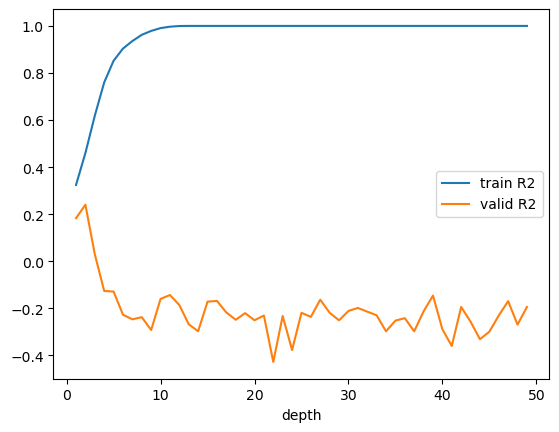

In [12]:
grid = {'max_depth':np.arange(1,50)}

dtree = DecisionTreeRegressor()
dtreeCV = GridSearchCV(dtree,param_grid=grid,return_train_score=True)
dtreeCV.fit(X_train,y_train)

print()
print('best alpha =',dtreeCV.best_params_, '  valid R2 =',dtreeCV.best_score_.round(3))

results = pd.DataFrame()
results['depth']    = grid['max_depth']
results['train R2'] = dtreeCV.cv_results_['mean_train_score']
results['valid R2'] = dtreeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train R2')
results.plot.line(x='depth',y='valid R2',ax=ax1)

In [13]:
predictions_df = pd.DataFrame({'TEAM':df_test['TEAM'],'Target':y_test, 'Predicted':y_pred})
predictions_df['MSE'] = (predictions_df['Target']-predictions_df['Predicted'])**2
predictions_df.sort_values(by ='Predicted',ascending = False)

,TEAM,Target,Predicted,MSE
25,Illinois,3,2.025641,0.949375
2,Arizona,2,2.025641,0.000657
3,Auburn,0,2.025641,4.103222
32,Marquette,2,2.025641,0.000657
23,Houston,2,2.025641,0.000657
...,...,...,...,...
22,Grand Canyon,1,0.173333,0.683378
27,James Madison,1,0.173333,0.683378
30,Long Beach St.,0,0.173333,0.030044
31,Longwood,0,0.173333,0.030044


In [14]:
grid = {'learning_rate':[0.01,0.1,1],'n_estimators':[100,2000],'max_depth':[1,2,3,4,5]}
gbt = GradientBoostingRegressor()
gbtCV = GridSearchCV(gbt,param_grid=grid,n_jobs=-1)
gbtCV.fit(X_train,y_train)
print('Gradient Boosting Trees:')
print(' Optimal Parameters:',gbtCV.best_estimator_)
print(' Optimal Valid R2 =',gbtCV.best_score_)

Gradient Boosting Trees:
 Optimal Parameters: GradientBoostingRegressor(max_depth=1)
 Optimal Valid R2 = 0.2791941490987306


<Axes: xlabel='Depth'>

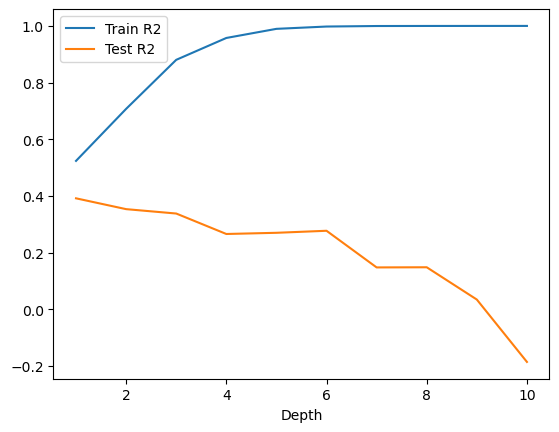

In [17]:
depths = [1,2,3,4,5,6,7,8,9,10]
Test_R2 = []
Train_R2 = []
depth = []
for i in range(len(depths)):
    gbt = GradientBoostingRegressor(max_depth=depths[i], n_estimators=500, learning_rate=0.01)
    gbt.fit(X_train,y_train)
    Test_R2.append(gbt.score(X_test, y_test))
    Train_R2.append(gbt.score(X_train,y_train))
    depth.append(depths[i])
 
results = pd.DataFrame()
results['Depth'] = depth
results['Train R2'] = Train_R2
results['Test R2'] = Test_R2
 
ax1 = results.plot(x = 'Depth', y = 'Train R2')
results.plot(x = 'Depth', y = 'Test R2', ax = ax1)